## Multi-label Legal Text Classification for CIA

### Data Collection

This study uses two main databases -- (1) a corpus of legal text and (2) a corpus of definitions of potential competition restrictions from the OECD. 

### I. Legal Texts

*Legal texts*

The input data used for this study is a collection of legal texts including bills, acts, resolutions, decrees, memorandums, executive orders, etc. The laws were collected from databases of two sample countries - Philippines and Singapore - in PDF format which were parsed and processed accordingly to transform them into a usable format. Each observation consists of a unique paragraph from a total of 36 pieces of legislation. After data cleaning and filtering out sections unrrelated to the substantive content of the law, 3,180 unique paragraphs remain. The usual text pre-processing steps such as removal of stopwords, punctuations, and numeric characters, as well as stemming and lemmatization were then performed.

##### a. Parsing

In [49]:
!pip install bs4
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [1]:
# main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# parsing
from glob import glob
import os 
import re

import pdfplumber
from pdfminer.high_level import extract_text
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator

In [3]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

In [4]:
countries = ["Brunei", "Indonesia", "Malaysia", "Philippines", "Singapore"]
dirs = []
for country in countries:
    dir = "data/legislation/" + str(country) + "/"
    dirs.append(dir)

pdf_list = []
for path in dirs:
    list = glob(os.path.join(path, "*.pdf"))
    pdf_list.extend(list)

len(pdf_list)

72

In [5]:
pdf_list

['data/legislation/Brunei/BN_Companies Act Chapter 39, 2016.pdf',
 'data/legislation/Brunei/BN_Post Office Act Chapter 52 1984.pdf',
 'data/legislation/Brunei/BN_Post Office Rules 1993.pdf',
 'data/legislation/Brunei/BN_Monopolies Act Chapter 73 2003.pdf',
 'data/legislation/Indonesia/IN_PR No. 44:2016 Negative Investment List.pdf',
 'data/legislation/Indonesia/IN_Law 14:2008 Public Information Disclosure.pdf',
 'data/legislation/Indonesia/IN_Law 40:2007 Limited Liability Companies.pdf',
 'data/legislation/Indonesia/IN_Regulation 7:2018 Electronically Integrated Business Licensing.pdf',
 'data/legislation/Indonesia/IN_Law 25:2007 Investment.pdf',
 'data/legislation/Indonesia/IN_Law 07:2014 Trade.pdf',
 'data/legislation/Indonesia/IN_Law 05:1999 Monopolistic Practices and Unfair Business Competition.pdf',
 'data/legislation/Indonesia/IN_Law 13:2003 Manpower.pdf',
 'data/legislation/Indonesia/IN_Law 19:2003 State-Owned Enterprises.pdf',
 'data/legislation/Indonesia/IN_Law 08:1995 Capital

Parse PDFs with pdfplumber

In [18]:
## DO NOT RUN (USE 2 LEVEL SPLIT)

def text_split(text):
    # find double line breaks
    if text.find("\n\n") != -1:
        split = text.split("\n\n")
    elif text.find("\n \n") != -1:
        split = text.split("\n \n")
    # find section/article divisions
    elif len(re.findall('\\n[A-Z]{2,}', text)) > 0:
        split = re.split('\\n[A-Z]{2,}', text)
    elif len(re.findall('\\nSection', text)) > 0:
        split = re.split('\\nSection', text)
    # find single line breaks
    elif text.find('\n“') != -1:
        split = text.split('\n“')
    else: 
        split = text
    return split

In [6]:
# TWO-LEVEL SPLIT

def text_split(text):
    # find double line breaks
    if text.find("\n\n") != -1:
        split = text.split("\n\n")
    elif text.find("\n \n") != -1:
        split = text.split("\n \n")
    # find section/article divisions
    elif len(re.findall('\\n[A-Z]{2,}', text)) > 0:
        split = re.split('\\n[A-Z]{2,}', text)
    elif len(re.findall('\\nSection', text)) > 0:
        split = re.split('\\nSection', text)
    # find single line breaks
    elif text.find('\n“') != -1:
        split = text.split('\n“')
    elif text.find('\\n') != -1:
        split = text.split('\\n')
    else: 
        split = [text]

    # second split
    if len(split) > 1:
        new_split = []
        for s in split:
            if s.find("\n\n") != -1:
                new_split += s.split("\n\n")
            elif s.find("\n \n") != -1:
                new_split += s.split("\n \n")
            elif len(re.findall('\\n[A-Z]{2,}', s)) > 0:
                new_split += re.split('\\n[A-Z]{2,}', s)
            elif len(re.findall('\\nSection', s)) > 0:
                new_split += re.split('\\nSection', s)
            elif s.find('\n“') != -1:
                new_split += s.split('\n“')
            elif s.find('\\n') != -1:
                new_split += s.split('\\n')
            else:
                new_split.append(s)
        split = new_split
    
    return split


Parsing by document

In [98]:
## DO NOT RUN (USE PARSING BY PARAGRAPH)

df_text = pd.DataFrame(columns = ['file_name', 'text', 'lang'])

for pdf_file in pdf_list:
        # search for pdf file name from path 
        file_name = re.search('[a-zA-Z0-9]*_([a-zA-Z0-9]+)[^\\>.]+', pdf_file)[0]
        with pdfplumber.open(pdf_file) as pdf:
            text = []
            # load pdf by page 
            for i in range(len(pdf.pages)):
                page = pdf.pages[i]
                page_text = page.extract_text()
                text.append(page_text)
            text = ' '.join(text)
            lang = detect(text)
        row = pd.DataFrame({'file_name': file_name,
                                'text': text, 'lang': lang}, index=[0])
        df_text = pd.concat([row,df_text.loc[:]]).reset_index(drop=True)

Parsing by paragraph

In [9]:
df_text = pd.DataFrame(columns = ['file_name', 'country', 'text', 'lang', 'length'])

for pdf_file in pdf_list:
        # search for pdf file name from path 
        file_name = re.search('[a-zA-Z0-9]*_([a-zA-Z0-9]+)[^\\>.]+', pdf_file)[0]
        country = re.search('^[A-Z]{2}', file_name)[0]
        with pdfplumber.open(pdf_file) as pdf:
            text = []
            # load pdf by page 
            for i in range(len(pdf.pages)):
                page = pdf.pages[i]
                page_text = page.extract_text()
                text.append(page_text)
            text = ' '.join(text)
            lang = detect(text)
            # split by paragraph 
            paragraphs = text_split(text)
            for p in paragraphs:
                paragraph = p
                length = paragraph.count(' ')
                # create dataframe
                row = pd.DataFrame({'file_name': file_name, 'country': country,
                        'text': paragraph, 'lang': lang, 'length': length}, index=[0])
                df_text = pd.concat([row,df_text.loc[:]]).reset_index(drop=True)

In [10]:
df_text

,file_name,country,text,lang,length
0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,369
1,SG_Public Consultation Paper on Draft Amendmen...,SG,"33A, and deletion of Section 24(5) of the PSA...",en,27
2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,444
3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,158
4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,140
...,...,...,...,...,...
7827,"BN_Companies Act Chapter 39, 2016",BN,EDITION 2015\nB.L.R.O. 2/2015 BLUV PROJECT\nI...,en,15
7828,"BN_Companies Act Chapter 39, 2016",BN,ACT\nEnactment No. 25 of 1956\nAmended by\nEn...,en,37
7829,"BN_Companies Act Chapter 39, 2016",BN,39,en,1
7830,"BN_Companies Act Chapter 39, 2016",BN,OF BRUNEI,en,2


In [11]:
df_text.file_name.value_counts()

PH_EO 292 Administrative Code 1987                     1255
BN_Companies Act Chapter 39, 2016                       972
PH_RA 7160 Local Government Code 1991                   693
PH_Constitution Republic of the Philippines 1987        356
PH_RA 9337 Amendments to Internal Revenue Code 2005     356
                                                       ... 
MY_Guidelines for Dispute Resolution July 2003            9
SG_Postal Services Act Regulation 2005                    7
SG_Guidelines for Express Letter Service 2019             7
SG_Postal Services Composition of Offences 2008           4
SG_Postal Accounting Separation Framework 2010            2
Name: file_name, Length: 72, dtype: int64

In [12]:
df_text.lang.value_counts()

en    7599
id     233
Name: lang, dtype: int64

In [13]:
df_text.length.value_counts().sort_index()

0       136
1       642
2       286
3       308
4       321
       ... 
4436      1
5810      1
5836      1
6430      1
6618      1
Name: length, Length: 812, dtype: int64

#### b. Cleaning and pre-processing

In [33]:
df = df_text

Remove links and white space characters

In [34]:
df.text = (
    df.text
    .replace("\n", " ", regex=True)
    .replace("(?:(?:https?|http):\/\/)?(?:www\.)?[a-zA-Z0-9\-]+\.[a-zA-Z0-9\-]+\.(?:[a-zA-Z0-9\-]+\.)?(?:com|html|ph|sg|org)(?:\/[^\s]*)?", 
             " ", regex=True))

In [35]:
df

,file_name,country,text,lang,length,text_clean
0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,233,v procedur and timefram for submit comment mci...
1,SG_Public Consultation Paper on Draft Amendmen...,SG,"33A, and deletion of Section 24(5) of the PSA...",en,16,33a delet section psa describ page annex a – p...
2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,274,psa provid would therefor requir postal servic...
3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,90,48a expand power search arrest dispos letter r...
4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,86,current spell consequ breach direct given mini...
...,...,...,...,...,...,...
7827,"BN_Companies Act Chapter 39, 2016",BN,EDITION 2015 B.L.R.O. 2/2015 BLUV PROJECT Inc...,en,12,edit b.l.r.o 2/2015 bluv project incorpor amen...
7828,"BN_Companies Act Chapter 39, 2016",BN,ACT Enactment No. 25 of 1956 Amended by Enact...,en,46,act enact no amend enact no s 89/1957 s 99/195...
7829,"BN_Companies Act Chapter 39, 2016",BN,39,en,0,
7830,"BN_Companies Act Chapter 39, 2016",BN,OF BRUNEI,en,1,of brunei


In [36]:
df.iloc[1200,2]

' 10. Prohibition Against the Imposition of Similar Charge on Users of Motor Vehicle.- No other Tax, fee or any other charge of similar nature, as the Motor Vehicle User’s Charge shall be imposed by any political subdivision or unit in the country. This provision shall apply to all motor vehicles, including tricycles, motorized pedicads and "trisikads".'

Removal of stopwords, punctuations, numeric characters

In [109]:
!pip install nltk

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [21]:
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
def preprocess_corpus(texts):
    eng_stopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        token_list =  [token.lower() for token in tokens if token not in eng_stopwords and token not in punctuation and token.isdigit() == False]
        processed_text = ' '.join(token_list)
        return processed_text
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

In [38]:
df['text_clean'] = preprocess_corpus(df['text'])

Stemming and lemmatization

In [39]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [40]:
def stem_lemmatize(text):
    stemmed = [stemmer.stem(token) for token in word_tokenize(text)]
    lemmatized = [lemmatizer.lemmatize(token) for token in stemmed]
    processed_text = ' '.join(lemmatized)
    return processed_text

In [41]:
df['text_clean'] = [stem_lemmatize(text) for text in df['text_clean']]

Filter number of words < 20

In [42]:
df['length'] = [x.count(' ') for x in df['text_clean']]
df = df[df['length'] > 20]
df

,file_name,country,text,lang,length,text_clean
0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,233,v procedur and timefram for submit comment mci...
2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,274,psa provid would therefor requir postal servic...
3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,90,48a expand power search arrest dispos letter r...
4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,86,current spell consequ breach direct given mini...
5,SG_Public Consultation Paper on Draft Amendmen...,SG,on the regulation of letter boxes. Enhancing ...,en,29,regul letter box enhanc enforc power psa today...
...,...,...,...,...,...,...
7809,"BN_Companies Act Chapter 39, 2016",BN,AND ARTICLES 23. Effect of memorandum and art...,en,31,and articl effect memorandum articl money paya...
7811,"BN_Companies Act Chapter 39, 2016",BN,OF COMPANIES 20. Restriction on registration ...,en,27,of compani restrict registr compani certain na...
7815,"BN_Companies Act Chapter 39, 2016",BN,OF ASSOCIATION 9. Articles prescribing regula...,en,25,of associ articl prescrib regul compani regul ...
7816,"BN_Companies Act Chapter 39, 2016",BN,OF ASSOCIATION 4. Mode of forming incorporate...,en,43,of associ mode form incorpor compani requir re...


In [47]:
df.file_name.value_counts()

PH_EO 292 Administrative Code 1987                  851
PH_RA 7160 Local Government Code 1991               498
BN_Companies Act Chapter 39, 2016                   397
PH_Constitution Republic of the Philippines 1987    202
PH_RA 9184 Government Procurement Act IRR 2016      180
                                                   ... 
SG_Postal Accounting Separation Framework 2010        2
SG_Postal Services Act Regulation 2005                2
BN_Monopolies Act Chapter 73 2003                     2
SG_Guidelines for Express Letter Service 2019         2
SG_Postal Services Composition of Offences 2008       1
Name: file_name, Length: 71, dtype: int64

In [44]:
df.lang.value_counts()

en    4085
id      58
Name: lang, dtype: int64

Remove non-english text

In [45]:
df['lang'] = [detect(x) for x in df['text_clean']]
df = df[df['lang'] == 'en']
df

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_42281/1540952126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = [detect(x) for x in df['text_clean']]


,file_name,country,text,lang,length,text_clean
0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,233,v procedur and timefram for submit comment mci...
2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,274,psa provid would therefor requir postal servic...
3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,90,48a expand power search arrest dispos letter r...
4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,86,current spell consequ breach direct given mini...
5,SG_Public Consultation Paper on Draft Amendmen...,SG,on the regulation of letter boxes. Enhancing ...,en,29,regul letter box enhanc enforc power psa today...
...,...,...,...,...,...,...
7806,"BN_Companies Act Chapter 39, 2016",BN,OF NUMBER OF MEMBERS BELOW LEGAL MINIMUM 31. ...,en,22,of number of member below legal minimum prohib...
7809,"BN_Companies Act Chapter 39, 2016",BN,AND ARTICLES 23. Effect of memorandum and art...,en,31,and articl effect memorandum articl money paya...
7811,"BN_Companies Act Chapter 39, 2016",BN,OF COMPANIES 20. Restriction on registration ...,en,27,of compani restrict registr compani certain na...
7816,"BN_Companies Act Chapter 39, 2016",BN,OF ASSOCIATION 4. Mode of forming incorporate...,en,43,of associ mode form incorpor compani requir re...


In [48]:
df.to_csv("data/legal_texts_pipeline.csv")

#### c. Descriptive statistics

### II. Definitions

In [50]:
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2image
!pip install "layoutparser[ocr]"

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /private/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/pip-install-2j98aain/detectron2_24ea01da83534c56a9eaa26f9bb3db83
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/pip-install-2j98aain/detectron2_24ea01da83534c56a9eaa26f9bb3db83
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py) ... done


In [124]:
import pdf2image
from pdf2image import convert_from_bytes, convert_from_path
from glob import glob
import layoutparser as lp
import collections.abc
from collections.abc import MutableMapping

In [125]:
def_dir = "data/definitions/" 
def_list = glob(os.path.join(def_dir, "*.pdf"))
len(def_list)

1

In [126]:
img_list = []
for pdf in def_list:
    # convert pdf to image
    file = convert_from_path(pdf)
    # read image as array
    for (i, page) in enumerate(file):
        img = np.asarray(file[i])
    # append to list 
        img_list.append(img)
    print('{} is done'.format(pdf) + ': ' + str(len(file)) + ' pages')

data/definitions/oecd-definitions.pdf is done: 15 pages


#### a. Document layout recognition
https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html#model-catalog

In [127]:
# model used for DLA
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.45], # if confidence score < 0.5, bounding box will not appear 
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [128]:
layout_results = []
for img in img_list:
    layout = model.detect(img)
    layout_results.append(layout)

/Users/janinedevera/opt/miniconda3/lib/python3.9/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/Users/janinedevera/opt/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_croot-4qf3nw4h/pytorch_1648016051178/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
len(layout_results)

15

In [10]:
layout_results[5]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=382.6321716308594, y_1=640.4793701171875, x_2=1316.7623291015625, y_2=681.00048828125), text=None, id=None, type=Title, parent=None, next=None, score=0.996715784072876), TextBlock(block=Rectangle(x_1=388.93243408203125, y_1=1252.96240234375, x_2=1030.2362060546875, y_2=1295.3704833984375), text=None, id=None, type=Title, parent=None, next=None, score=0.9871305823326111), TextBlock(block=Rectangle(x_1=328.6932067871094, y_1=1557.092529296875, x_2=701.5183715820312, y_2=1601.2904052734375), text=None, id=None, type=Title, parent=None, next=None, score=0.9866315722465515), TextBlock(block=Rectangle(x_1=329.71148681640625, y_1=975.97900390625, x_2=700.8331298828125, y_2=1022.7642211914062), text=None, id=None, type=Title, parent=None, next=None, score=0.9819469451904297), TextBlock(block=Rectangle(x_1=325.14434814453125, y_1=704.9537353515625, x_2=1321.0994873046875, y_2=948.52783203125), text=None, id=None, type=Text, parent=None, next=None, s

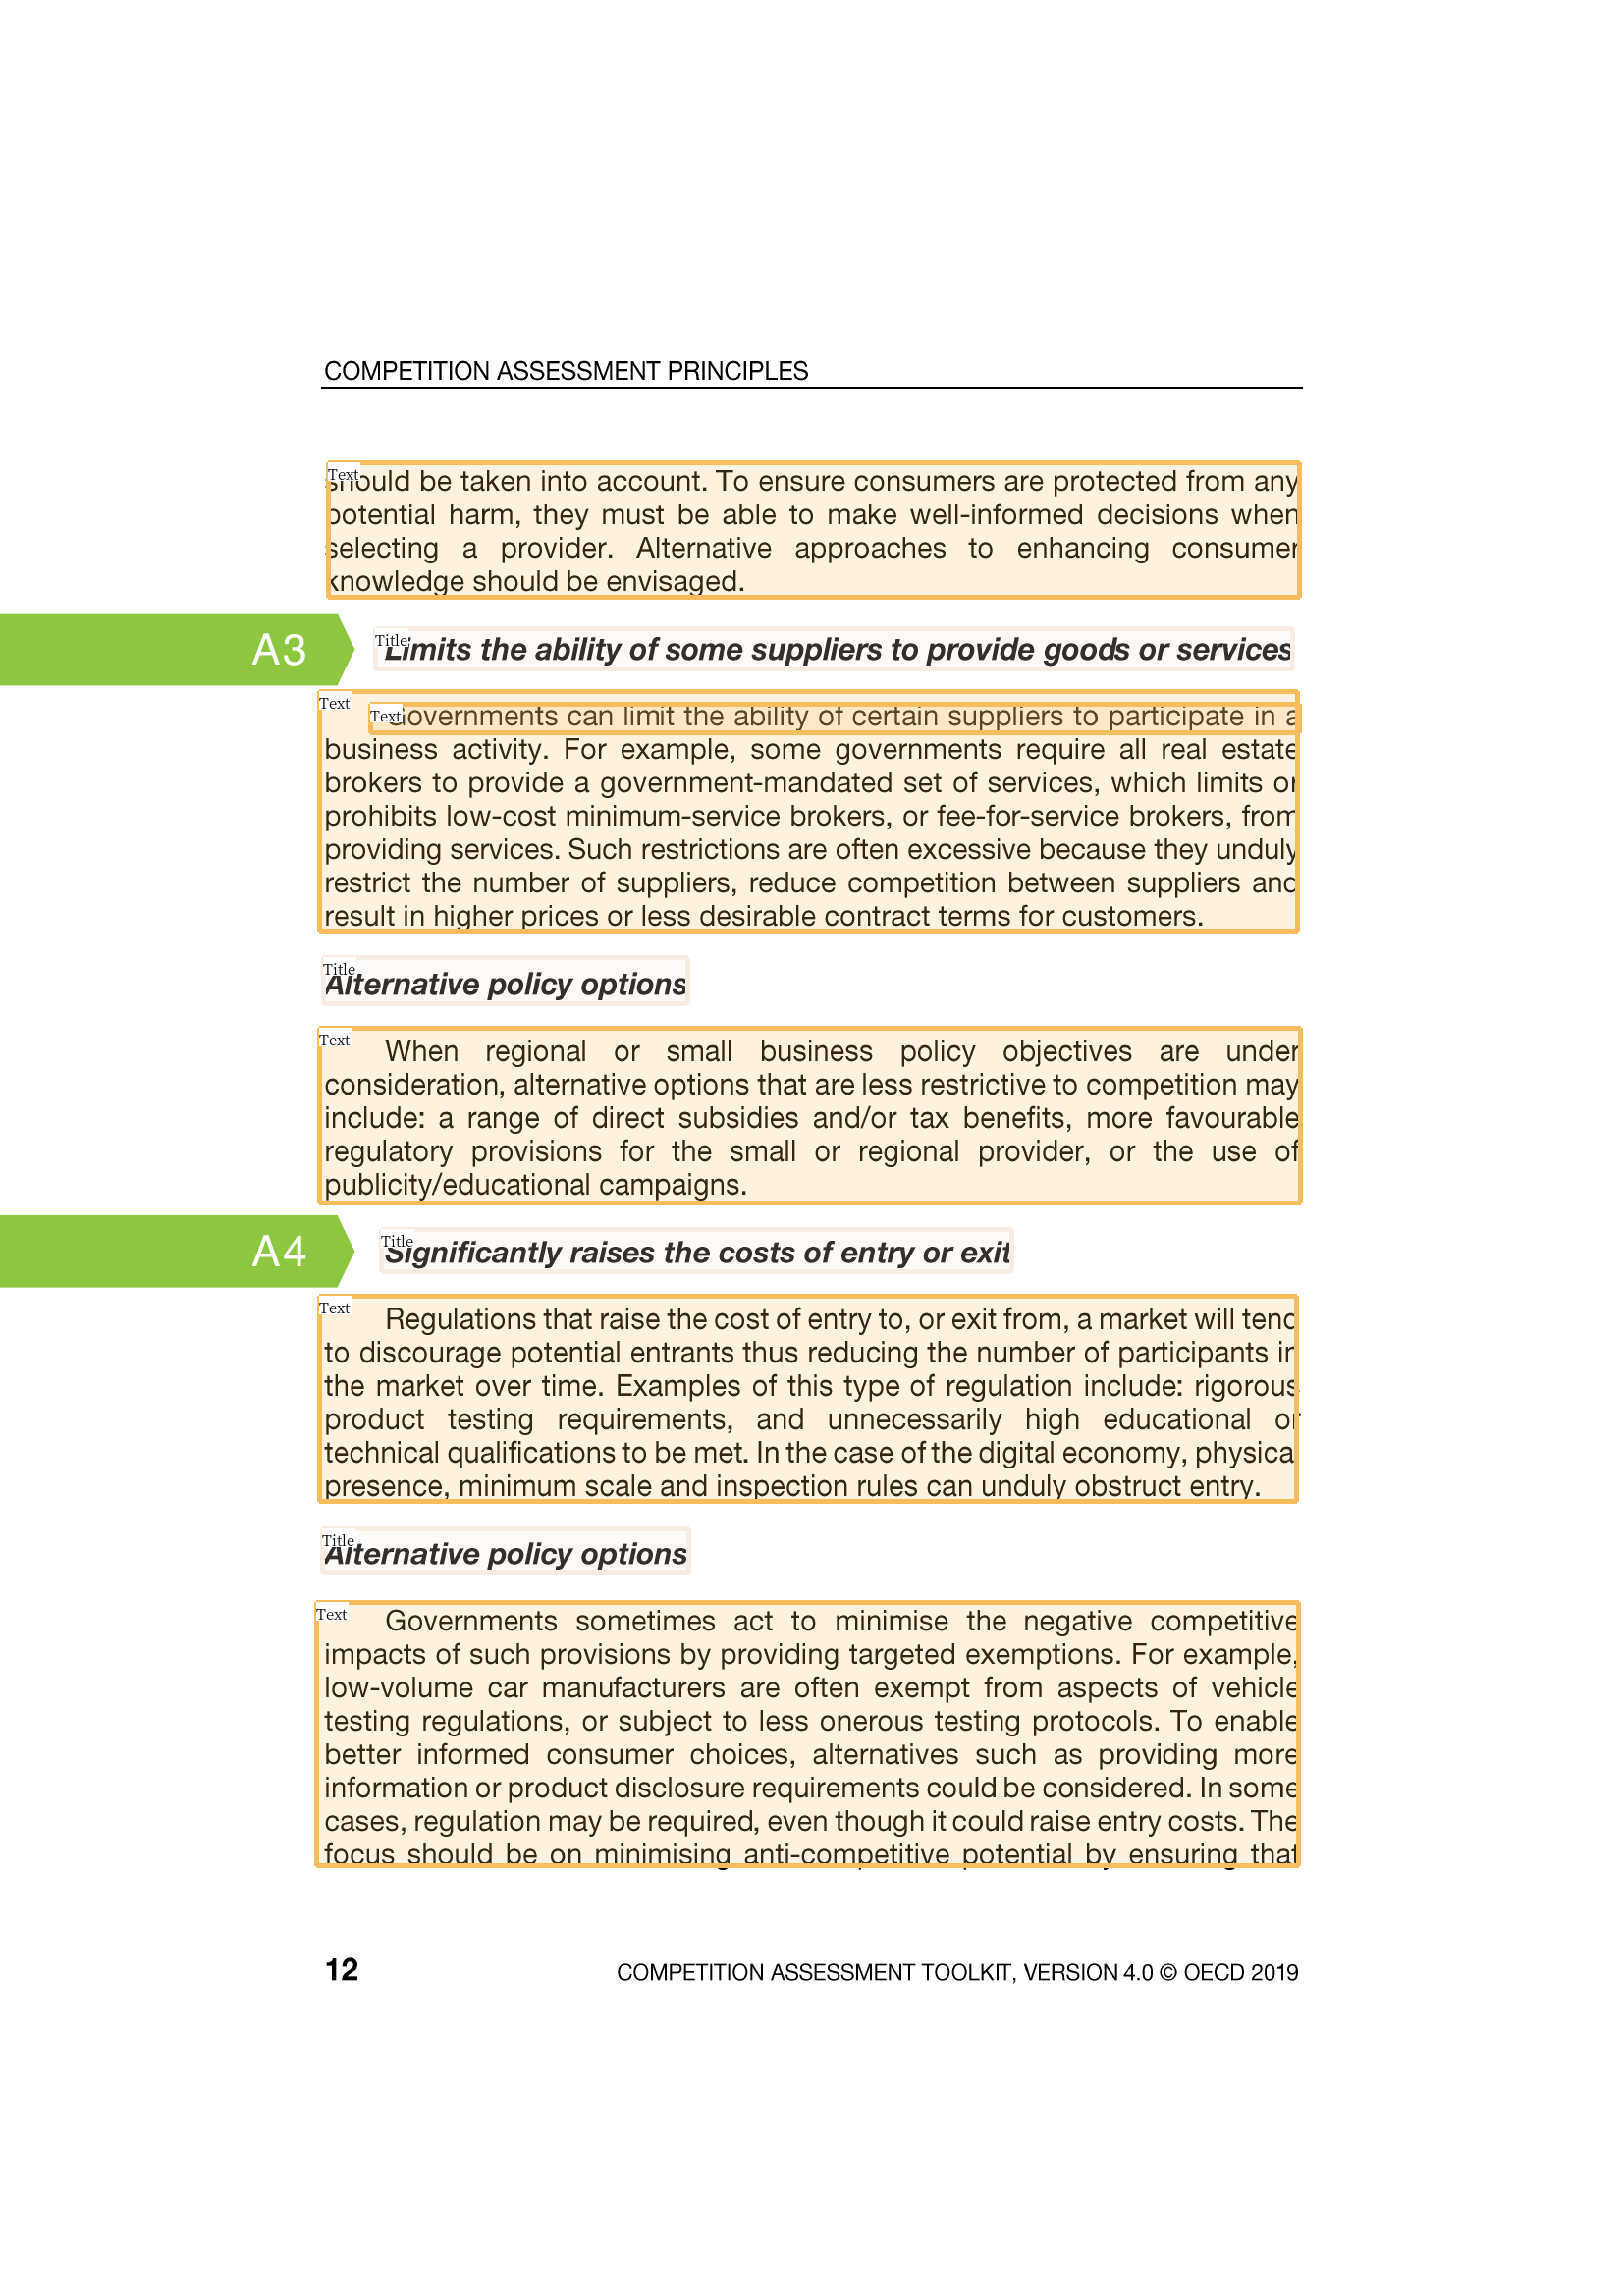

In [11]:
lp.draw_box(img_list[5], layout_results[5],  box_width=5, box_alpha=0.2, show_element_type=True)

Function for extracting text from OCR results

In [65]:
def extract_section(section, results, images):

    # select relevant sections 
    list = []
    for result in results:
        item = lp.Layout([b for b in result if b.type==section]) 
        list.append(item)

    # ocr selected sections
    ocr_agent = lp.TesseractAgent(languages='eng')
    ocr_section = []
    for item, img in zip(list, images): 
        for block in item:
            # crop image around the detected layout
            segment_image = (block
                            .pad(left=15, right=15, top=5, bottom=5)
                            .crop_image(img))
            # perform ocr
            text = ocr_agent.detect(segment_image)
            # save result
            block.set(text=text, inplace=True)
        ocr_section.append(item)

    # create list of text
    final_text = []
    for file in ocr_section:
        for text in file:
            final_text.append(text.text.strip())

    return final_text

In [ ]:
titles = extract_section("Title", layout_results, img_list)

In [91]:
titles = [x for x in titles if x != 'Alternative policy options']
titles = [x.replace("\n", " ") for x in titles]

In [92]:
titles

['Chapter 1  Competition Assessment and the Competition Checklist',
 'Introduction',
 'Are there limits on the number or range of suppliers?',
 'Grants of exclusive rights',
 'License or permit requirements',
 'Limits the ability of some suppliers to provide goods or services',
 'Significantly raises the costs of entry or exit',
 'Restricts the geographic flow of goods, services, capital and labour',
 'requirements to achieve an adequate degree of consumer protection are set at the minimum mandatory level.',
 'There is a substantial risk of “temporary” protection developing into a quasi-permanent arrangement as a result of substantial lobbying by suppliers benefitting from the restrictions.',
 'Controls the prices at which goods or services are sold',
 'Are there limits on suppliers’ ability to compete?',
 'Sets standards for product quality that provide an undue advantage to some suppliers over others, or are above the level that some well-informed customers choose',
 'Restricts adver

In [99]:
pd.DataFrame(titles).to_csv("data/def_titles.csv")

In [86]:
text = extract_section("Text", layout_results, img_list)

In [96]:
text = [x.replace("\n", " ") for x in text]
text

['Examples of the benefits of competition are provided in Chapter 2.',
 'This chapter describes the Competition Checklist and its role in the competition assessment process. Readers with prior knowledge of this topic may wish to  proceed directly to the technical companion volume, Competition Assessment Guidance.',
 'As a first step, the method employs a “Competition Checklist”, a set of threshold questions which indicate when a proposed law or regulation may have significant potential to harm competition. The Checklist helps policymakers focus on potential competition issues at an early stage in the policy development process.',
 'The Toolkit shows regulators and legislators how to make that assessment. It provides a practical method to identify important competitive restrictions and, if possible, how to avoid them. In 2009, the OECD Council adopted a Recommendation on Competition Assessment (see Appendix A for the full text of the recommendation).',
 'Government action is designed to

In [100]:
pd.DataFrame(text).to_csv("data/def_text.csv")

#### b. Read complete definitions table

In [129]:
definitions = pd.read_excel("data/oecd_definitions.xlsx")


In [130]:
definitions['length'] = [x.count(' ') for x in definitions['Text']]

In [131]:
definitions

,Main_Cat,Sub_Cat,Text,length
0,A,NaN,Limiting the number of suppliers leads to the ...,118
1,A,A1,Granting an exclusive right to produce a certa...,172
2,A,A2,Licenses or permits required for operation nec...,176
3,A,A3,Governments can limit the ability of certain s...,71
4,A,A4,"Regulations that raise the cost of entry to, o...",149
5,A,A5,"Regulations sometimes limit the flow of goods,...",142
6,B,NaN,Regulation can affect a supplier's ability to ...,50
7,B,B1,Governments often regulate prices in tradition...,177
8,B,B2,Regulations that restrict supplier's ability t...,141
9,B,B3,Regulations setting standards often provide be...,193


#### c. Cleaning and pre-processing

In [133]:
definitions['text_clean'] = preprocess_corpus(definitions['Text'])
definitions['text_clean'] = [stem_lemmatize(text) for text in definitions['text_clean']]

In [134]:
definitions

,Main_Cat,Sub_Cat,Text,length,text_clean
0,A,NaN,Limiting the number of suppliers leads to the ...,118,limit number supplier lead risk market power c...
1,A,A1,Granting an exclusive right to produce a certa...,172,grant exclus right produc certain good provid ...
2,A,A2,Licenses or permits required for operation nec...,176,licens permit requir oper necessarili restrict...
3,A,A3,Governments can limit the ability of certain s...,71,govern limit abil certain supplier particip bu...
4,A,A4,"Regulations that raise the cost of entry to, o...",149,regul rais cost entri exit market tend discour...
5,A,A5,"Regulations sometimes limit the flow of goods,...",142,regul sometim limit flow good servic capit and...
6,B,NaN,Regulation can affect a supplier's ability to ...,50,regul affect supplier 's abil compet varieti w...
7,B,B1,Governments often regulate prices in tradition...,177,govern often regul price tradit monopoli secto...
8,B,B2,Regulations that restrict supplier's ability t...,141,regul restrict supplier 's abil advertis marke...
9,B,B3,Regulations setting standards often provide be...,193,regul set standard often provid benefit consum...


In [137]:
definitions.to_csv("data/oecd_definitions_preprocess.csv")